In [1]:
# Run the command below if necessary, for example with Google Colab
#!pip3 install mxnet-cu110

In [16]:
# Global Libs
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pickle
import random

# Local libs
import model

In [3]:
with open("losses.pkl", "rb") as f:
    training_loss, validation_loss = pickle.load(f)

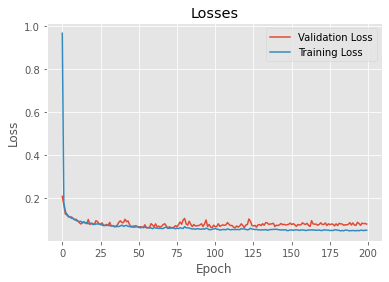

In [64]:
# plot the losses
epochs = 200

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.show()

In [14]:
# Qualitative Evaluation

# Load Best Model
model_file_name = "net.params"
ctx = mx.gpu()

net = model.create_regression_network()
net.load_parameters(model_file_name, ctx=ctx)

[18:41:35] ../src/base.cc:80: cuDNN lib mismatch: linked-against version 8101 != compiled-against version 8100.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


In [22]:
# Loading data for evaluation
# Saving data to analyse further
with open("data.pkl", "rb") as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

with open("scaled_data.pkl", "rb") as f:
    (scaled_X_train_onehot_df, scaled_X_val_onehot_df, scaled_X_test_onehot_df, sc_X,
     scaled_y_train, scaled_y_val, scaled_y_test, sc_y) = pickle.load(f)

In [23]:
random_index = random.randrange(0, len(X_test))
# scaled_input = mx.nd.array([scaled_X_test[random_index]])
scaled_input = mx.nd.array([scaled_X_train_onehot_df.values[random_index]])

# Unscaled Expected Output
expected_output = y_test[random_index]
print("Unscaled Expected Output:", expected_output)

# Scaled Expected Output
scaled_expected_output = scaled_y_test[random_index]
print("Scaled Expected Output:", scaled_expected_output)

# Model Output (scaled)
output = net(scaled_input.as_in_context(ctx)).asnumpy()[0]
print("Model Output (scaled):", output)

# Unscaled Output
unscaled_output = sc_y.inverse_transform(output)
print("Unscaled Output:", unscaled_output)

# Absolute Error
abs_error = abs(expected_output - unscaled_output)
print("Absolute error: ", abs_error)

# Percentage Error
perc_error = abs_error / expected_output * 100.0
print("Percentage Error: ", perc_error)

Unscaled Expected Output: [380000.]
Scaled Expected Output: [-0.4304741]
Model Output (scaled): [-0.45450553]
Unscaled Output: [370690.]
Absolute error:  [9310.]
Percentage Error:  [2.45]


In [37]:
# Quantitative Evaluation

# Evaluating on Test Set (unseend data)
expected_outputs = y_test

# Model Outputs (common for all quantitative evaluations)
inputs = mx.nd.array(scaled_X_test_onehot_df.values, ctx=ctx)
outputs = net(inputs)

# Transform to numpy (CPU)
outputs = outputs.asnumpy()

unscaled_outputs = sc_y.inverse_transform(outputs)

In [43]:
# Mean Absolute Error
abs_error = abs(expected_outputs - unscaled_outputs)
mae = sum(abs_error) / len(abs_error)

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): [81103.97]


In [44]:
# Mean Absolute Percentage Error
perc_error = abs_error / expected_outputs * 100.0
mape = sum(perc_error) / len(perc_error)

print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): [16.008343]


In [65]:
# Thresholds and Percentage
# How many houses in our dataset have been correctly estimated?
# We deem an estimation to be correct, when the error in the value is less than 20%
perc_threshold = 25.0

houses_in_threshold = (perc_error <= perc_threshold)
number_houses_in_threshold = sum(houses_in_threshold)

number_houses_in_threshold_perc = 100.0 * number_houses_in_threshold / len(perc_error)

print("% Houses with a predicted price error below", str(perc_threshold), "%:", number_houses_in_threshold_perc)

% Houses with a predicted price error below 25.0 %: [81.23987971]


In [66]:
# Calculate the % of houses depending on the threshold
perc_thresholds = np.arange(0, 100, 0.1)

houses_percentages = []
for perc_threshold in perc_thresholds:
    houses_in_threshold = (perc_error <= perc_threshold)
    number_houses_in_threshold = sum(houses_in_threshold)
    number_houses_in_threshold_perc = 100.0 * number_houses_in_threshold / len(perc_error)
    
    houses_percentages.append(number_houses_in_threshold_perc)

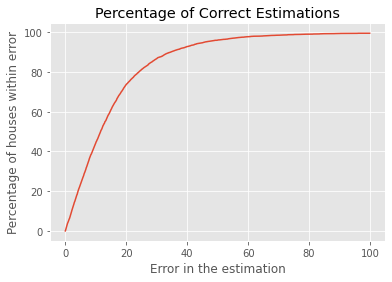

In [68]:
# plot the graph
plt.style.use("ggplot")
plt.figure()
plt.plot(perc_thresholds, houses_percentages)
plt.xlabel("Error in the estimation")
plt.ylabel("Percentage of houses within error")
plt.title("Percentage of Correct Estimations")
plt.show()